# Data Pre-processing

In [1]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

sns.set()

### Load data

In [2]:
# Read in data
all_files = glob.glob('./results*.txt')

# Concatenate the different files into a single dataframe
li = []
for filename in all_files:
    df = pd.read_csv(filename, sep=",", header=None)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)
df.columns = ["id", "idx", "filename", "label", "time"]
df['label_'] = df['label'].values == 'Smiling'

df.head()

,id,idx,filename,label,time,label_
0,42,1,1_1_2_20161219161757030.jpg.chip.jpg,Not smiling,1.4754,False
1,42,2,1_0_2_20161219194849659.jpg.chip.jpg,Not smiling,0.8943,False
2,42,3,1_0_2_20161219205702141.jpg.chip.jpg,Not smiling,0.5393,False
3,42,4,1_1_2_20161219155926197.jpg.chip.jpg,Not smiling,0.6319,False
4,42,5,1_1_2_20161219200456451.jpg.chip.jpg,Not smiling,0.5440,False


### Filter data

In [3]:
# Filter out low and high reaction times
df = df[(df['time'] > 0.2) & (df['time'] < 1)]

### Get normalized reaction times

In [4]:
# Create a new column with normalized times
scaler = MinMaxScaler()
for id_ in df['id'].unique():
    mask_ = df['id'] == id_
    scaler.fit(df.loc[mask_, ['time']])
    df.loc[mask_, 'time_norm'] = scaler.transform(df.loc[mask_, ['time']])

### Create the continuous index

In [5]:
# Create a mask for smile labels
smile_mask = df['label'] == 'Smiling'

# Create continuous index from -1 to 1
df.loc[~smile_mask, 'cidx'] = (1 - df.loc[~smile_mask, 'time_norm'])
df.loc[smile_mask, 'cidx'] = (df.loc[smile_mask, 'time_norm'] - 1)
df.head()

,id,idx,filename,label,time,label_,time_norm,cidx
1,42,2,1_0_2_20161219194849659.jpg.chip.jpg,Not smiling,0.8943,False,0.856935,0.143065
2,42,3,1_0_2_20161219205702141.jpg.chip.jpg,Not smiling,0.5393,False,0.339215,0.660785
3,42,4,1_1_2_20161219155926197.jpg.chip.jpg,Not smiling,0.6319,False,0.474260,0.525740
4,42,5,1_1_2_20161219200456451.jpg.chip.jpg,Not smiling,0.5440,False,0.346070,0.653930
5,42,6,1_0_2_20161219222555031.jpg.chip.jpg,Not smiling,0.4950,False,0.274610,0.725390


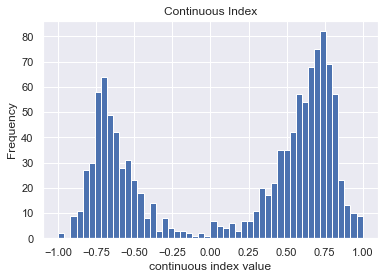

In [6]:
# plot the distribution of the index
plt.figure()
df['cidx'].plot(kind='hist', bins=50, title="Continuous Index")
plt.xlabel('continuous index value')
plt.savefig('./results/cidx.png', dpi=None, facecolor='w', edgecolor='w',)
plt.show()

Average the continuous index between the different subjects

In [7]:
# Average out the cidx
df_avg = df.groupby('filename').agg({'cidx': 'mean'})
df_avg.head()

,cidx
filename,
1_0_2_20161219140525218.jpg.chip.jpg,0.657185
1_0_2_20161219140530307.jpg.chip.jpg,-0.623345
1_0_2_20161219140540938.jpg.chip.jpg,-0.686351
1_0_2_20161219141817185.jpg.chip.jpg,-0.709593
1_0_2_20161219141912009.jpg.chip.jpg,-0.749103


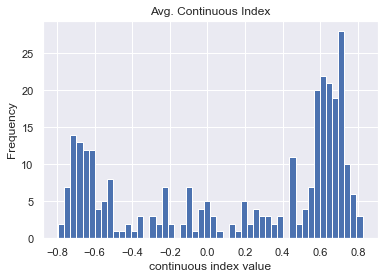

In [8]:
# Plot and save the cidx and average cidx
plt.figure()
df_avg['cidx'].plot(
    kind='hist', bins=50, 
    title="Avg. Continuous Index", 
    xlabel='s'
)
plt.xlabel('continuous index value')
plt.savefig('./results/cidx_avg.png', dpi=None, facecolor='w', edgecolor='w',)
plt.show()

### Save to csv

In [9]:
# Save the two dataframes as csv files
df.to_csv("./results/processed_data.csv", index=False)
df_avg.to_csv("./results/cidx_avg.csv", index=True)